## Multi-lingual example for using Wikimedia dump across languages

- Through **OpenLLM-France**, providing https://huggingface.co/datasets/OpenLLM-France/wikimedia



In [116]:
import getout_of_text_3 as got3
import datasets

from torch.utils.data import DataLoader
from tqdm import tqdm
from itertools import islice
import pandas as pd


In [117]:
# Dictionary mapping language codes to the word for 'vehicle' in each language
vehicle_dict = {
    "en": "bank",
    "fr": "banque",
    "es": "banco"
}

# Prepare a results dictionary grouped by language code
results_by_lang = {lang: [] for lang in vehicle_dict.keys()}

In [118]:
# Initialize results dictionary with language as top-level key
results = {lang: [] for lang in vehicle_dict.keys()}

# Loop through each language and its corresponding vehicle term
for lang_code, vehicle_term in vehicle_dict.items():
    print(f"🌍 Processing {lang_code.upper()} language - searching for '{vehicle_term}'")
    
    # Load dataset for the current language
    ds = datasets.load_dataset("OpenLLM-France/wikimedia", lang_code,
        streaming=True,
        split='train'
    )
    
    # Use islice to create a finite iterable
    TAKE_SIZE = 50000  # or any number you want
    limited_ds = list(islice(ds, TAKE_SIZE))
    
    print(' ✅ Total documents loaded:', len(limited_ds))
    print(f"📊 Processing {len(limited_ds)} documents for {lang_code}")
    
    
    # Process each document and create DataFrames, filtering actual occurrences
    lang_results = []
    for data in tqdm(limited_ds, desc=f"Processing {lang_code}"):
        text_content = data.get('text', '')
        # Skip documents that do not contain the vehicle term
        if vehicle_term.lower() not in text_content.lower():
            continue
        item_id = data['id']
        
        # Remove the 'id' key for the DataFrame
        data_clean = {k: v for k, v in data.items() if k != 'id'}
        
        # Convert to DataFrame (single row)
        df = pd.DataFrame([data_clean])
        lang_results.append(df)
    
    # Store all DataFrames for this language
    results[lang_code] = lang_results
    print(f"✅ Completed {lang_code}: {len(lang_results)} DataFrames stored (filtered for '{vehicle_term}')")

print(f"🎉 All languages processed! Results structure: {[f'{k}: {len(v)} documents' for k, v in results.items()]}")
print('Number of languages:', len(results.keys()))

for lang, docs in results.items():
    print(f'number of {lang.upper()} hits for {vehicle_dict[lang.lower()]}:', len(docs))


🌍 Processing EN language - searching for 'bank'
 ✅ Total documents loaded: 50000
📊 Processing 50000 documents for en


Processing en: 100%|██████████| 50000/50000 [00:00<00:00, 84307.92it/s] 


✅ Completed en: 2194 DataFrames stored (filtered for 'bank')
🌍 Processing FR language - searching for 'banque'
 ✅ Total documents loaded: 50000
📊 Processing 50000 documents for fr


Processing fr: 100%|██████████| 50000/50000 [00:00<00:00, 112360.29it/s]


✅ Completed fr: 649 DataFrames stored (filtered for 'banque')
🌍 Processing ES language - searching for 'banco'
 ✅ Total documents loaded: 50000
📊 Processing 50000 documents for es


Processing es: 100%|██████████| 50000/50000 [00:00<00:00, 102085.37it/s]

✅ Completed es: 793 DataFrames stored (filtered for 'banco')
🎉 All languages processed! Results structure: ['en: 2194 documents', 'fr: 649 documents', 'es: 793 documents']
Number of languages: 3
number of EN hits for bank: 2194
number of FR hits for banque: 649
number of ES hits for banco: 793


In [119]:
# save results to an outfile as a sampling of the data
import json
with open('wikimedia_{}_results.json'.format(vehicle_dict["en"]), 'w', encoding='utf-8') as f:
    json.dump({lang: [df.to_dict(orient='records')[0] for df in dfs] for lang, dfs in results.items()}, f, ensure_ascii=False, indent=4)

In [120]:
# Display results structure and sample data
print("📋 Results Summary:")
for lang, dataframes in results.items():
    print(f"  {lang.upper()}: {len(dataframes)} documents")
    if dataframes:
        print(f"    Sample columns: {list(dataframes[0].columns)}")
        print(f"    First document preview: {dataframes[0].head(1).to_dict('records')[0] if len(dataframes) > 0 else 'No data'}")
    print()

📋 Results Summary:
  EN: 2194 documents
    Sample columns: ['title', 'url', 'language', 'source', 'text']
    First document preview: {'title': 'Goodies in the Nick', 'url': 'https://en.wikipedia.org/wiki/Goodies_in_the_Nick', 'language': 'en', 'source': 'wikipedia', 'text': '# Goodies in the Nick\n\n"Goodies in the Nick" (also known as "The Great Goodies Bank Robbery" and "Bank Robbery") is an episode of the British comedy television series The Goodies. Written by The Goodies, with songs and music by Bill Oddie.\n\n## Plot\n\nThe Goodies are asked by a cowardly Police Sergeant to help him gain a promotion. Tim, Graeme and Bill decide to commit a crime so that the Police Sergeant can catch them and earn his promotion that way.\nThey turn up at a bank, dressed as gangsters and carrying violin cases, and hold up the bank. When they ask for the safe to be opened, they are told that there is no money being kept there — so they ask for a cheque to the value of money which was usually kept 

In [121]:
results.keys()

dict_keys(['en', 'fr', 'es'])

In [122]:
results['fr'][0]

,title,url,language,source,text
0,Agriculture en Libye,https://fr.wikipedia.org/wiki/Agriculture_en_L...,fr,wikipedia,# Agriculture en Libye\n\nBien que l'agricultu...


In [123]:
# Flatten the per-language lists into individual keys 'lang_index'
flattened_results = {}
for lang, dfs in results.items():
    for idx, df in enumerate(dfs):
        key = f"{lang}_{idx}"
        flattened_results[key] = df

print(f"🔄 Flattened results contain {len(flattened_results)} DataFrames")
# Display a few sample keys
print(list(flattened_results.keys())[:10])

🔄 Flattened results contain 3636 DataFrames
['en_0', 'en_1', 'en_2', 'en_3', 'en_4', 'en_5', 'en_6', 'en_7', 'en_8', 'en_9']


In [124]:
flattened_results.keys()

dict_keys(['en_0', 'en_1', 'en_2', 'en_3', 'en_4', 'en_5', 'en_6', 'en_7', 'en_8', 'en_9', 'en_10', 'en_11', 'en_12', 'en_13', 'en_14', 'en_15', 'en_16', 'en_17', 'en_18', 'en_19', 'en_20', 'en_21', 'en_22', 'en_23', 'en_24', 'en_25', 'en_26', 'en_27', 'en_28', 'en_29', 'en_30', 'en_31', 'en_32', 'en_33', 'en_34', 'en_35', 'en_36', 'en_37', 'en_38', 'en_39', 'en_40', 'en_41', 'en_42', 'en_43', 'en_44', 'en_45', 'en_46', 'en_47', 'en_48', 'en_49', 'en_50', 'en_51', 'en_52', 'en_53', 'en_54', 'en_55', 'en_56', 'en_57', 'en_58', 'en_59', 'en_60', 'en_61', 'en_62', 'en_63', 'en_64', 'en_65', 'en_66', 'en_67', 'en_68', 'en_69', 'en_70', 'en_71', 'en_72', 'en_73', 'en_74', 'en_75', 'en_76', 'en_77', 'en_78', 'en_79', 'en_80', 'en_81', 'en_82', 'en_83', 'en_84', 'en_85', 'en_86', 'en_87', 'en_88', 'en_89', 'en_90', 'en_91', 'en_92', 'en_93', 'en_94', 'en_95', 'en_96', 'en_97', 'en_98', 'en_99', 'en_100', 'en_101', 'en_102', 'en_103', 'en_104', 'en_105', 'en_106', 'en_107', 'en_108', 'en_109',

## Tools for multi-lingual analysis

- Will use this to pass got3 kwic results from the dataset random sampling

In [125]:
# WIKIMEDIA Computational Forensic Linguistics Agent
# Enhanced for multi-lingual analysis with language-keyword mapping

from langchain.tools import BaseTool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.chat_models import init_chat_model
from typing import Optional, Type, Dict, Any, Union, List
import json
import re
from datetime import datetime


class WikimediaAnalysisInput(BaseModel):
    """Input for WIKIMEDIA corpus linguistics analysis tool."""
    keyword: Optional[str] = Field(
        default=None, 
        description="Single keyword for analysis (legacy mode)"
    )
    keyword_dict: Optional[Dict[str, str]] = Field(
        default=None,
        description="Dictionary mapping language codes to keywords (e.g., {'en': 'vehicle', 'fr': 'véhicule', 'es': 'vehículo'})"
    )
    results_json: Union[str, Dict[str, Any]] = Field(
        description="Pre-filtered WIKIMEDIA KWIC JSON results from got3.search_keyword_corpus"
    )
    analysis_focus: Optional[str] = Field(
        default="forensic_linguistics", 
        description="Analysis approach: 'forensic_linguistics', 'semantic_variation', 'register_analysis', 'diachronic', 'comparative'"
    )
    max_contexts: Optional[int] = Field(
        default=None, description="DEPRECATED: No longer used. Tool processes all provided contexts."
    )
    return_json: bool = Field(
        default=False, description="If True, return structured JSON with reasoning and findings"
    )
    extraction_strategy: str = Field(
        default="all",
        description="Text extraction: 'first', 'all', or 'raw_json'"
    )
    debug: bool = Field(default=False, description="Enable debug metrics")


class WIKIMEDIAForensicLinguisticsTool(BaseTool):
    """
    AI tool for computational forensic linguistics analysis of WIKIMEDIA KWIC results.
    
    Enhanced for multi-lingual analysis - can accept either a single keyword or
    a dictionary mapping language codes to their respective keywords.
    
    Applies systematic data science, legal scholarship, and applied linguistics 
    methodologies to analyze keyword usage patterns across WIKIMEDIA languages and genres.
    """
    name: str = "WIKIMEDIA_forensic_analysis"
    description: str = (
        "Performs computational forensic linguistics analysis on WIKIMEDIA KWIC results "
        "with support for multi-lingual keyword analysis using data science and applied linguistics methodologies."
    )
    args_schema: Type[BaseModel] = WikimediaAnalysisInput
    model: Any = Field(exclude=True)

    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def _run(
        self,
        keyword: Optional[str] = None,
        keyword_dict: Optional[Dict[str, str]] = None,
        results_json: Union[str, Dict[str, Any]] = None,
        analysis_focus: str = "forensic_linguistics",
        max_contexts: Optional[int] = None,
        return_json: bool = False,
        extraction_strategy: str = "all",
        debug: bool = False,
    ) -> Union[str, Dict[str, Any]]:
        try:
            return self._execute(keyword, keyword_dict, results_json, analysis_focus, max_contexts, return_json, extraction_strategy, debug)
        except Exception as e:
            error_str = str(e)
            return f"❌ Error during WIKIMEDIA forensic analysis: {error_str}"

    async def _arun(
        self,
        keyword: Optional[str] = None,
        keyword_dict: Optional[Dict[str, str]] = None,
        results_json: Union[str, Dict[str, Any]] = None,
        analysis_focus: str = "forensic_linguistics",
        max_contexts: Optional[int] = None,
        return_json: bool = False,
        extraction_strategy: str = "all",
        debug: bool = False,
    ) -> Union[str, Dict[str, Any]]:
        return self._run(keyword, keyword_dict, results_json, analysis_focus, max_contexts, return_json, extraction_strategy, debug)

    def _execute(self, keyword, keyword_dict, results_json, analysis_focus, max_contexts, return_json, extraction_strategy, debug):
        # Validate input parameters
        if not keyword and not keyword_dict:
            raise ValueError("Either 'keyword' or 'keyword_dict' must be provided")
        
        # Parse and validate input - now handles both formats
        results_dict = self._parse_WIKIMEDIA_results(results_json)
        
        # Determine analysis mode and prepare keyword info
        if keyword_dict:
            # Multi-lingual mode
            analysis_keywords = keyword_dict
            analysis_type = "multilingual"
            primary_keyword = f"multilingual_analysis_{list(keyword_dict.values())[0]}"
        else:
            # Single keyword mode (legacy)
            analysis_keywords = {"unknown": keyword}
            analysis_type = "single"
            primary_keyword = keyword
        
        stats = self._compute_WIKIMEDIA_stats(results_dict, analysis_keywords, extraction_strategy)
        
        # Extract contexts and estimate token usage
        contexts = self._extract_contexts(results_dict, max_contexts, extraction_strategy)
        
        # Debug metrics
        if debug:
            print(f"✅ Reading WIKIMEDIA results for {analysis_type} analysis")
            print(f"📝 Keywords: {analysis_keywords}")
            raw_chars = len(json.dumps(results_dict, default=str))
            extracted_chars = sum(len(c) for c in contexts)
            print(f"🧪 WIKIMEDIA DEBUG: language_keys={len(results_dict)} raw_chars={raw_chars} extracted_chars={extracted_chars} total_contexts={len(contexts)}")
            
            # Debug: Show language distribution in ALL extracted contexts
            lang_context_counts = {}
            for context in contexts:
                if context.startswith('[') and ':' in context:
                    lang = context.split(':')[0][1:]  # Extract language from [lang:document_id]
                    lang_context_counts[lang] = lang_context_counts.get(lang, 0) + 1
            print(f"🎯 All extracted contexts by language: {lang_context_counts}")
            print(f"📊 Total contexts extracted: {len(contexts)}")
        
        # Build specialized prompt
        prompt = self._build_WIKIMEDIA_prompt(analysis_keywords, results_dict, stats, analysis_focus, max_contexts, return_json, extraction_strategy)
        
        # Invoke model
        response = self.model.invoke([{"role": "user", "content": prompt}])
        content = getattr(response, 'content', str(response))
        
        if return_json:
            return self._postprocess_WIKIMEDIA_json(content, stats, analysis_keywords)
        return content

    def _safe_str_conversion(self, obj):
        """Safely convert any object to string, handling nested structures."""
        if isinstance(obj, str):
            return obj
        elif isinstance(obj, (list, tuple)):
            return " | ".join(str(item) for item in obj if item)
        elif isinstance(obj, dict):
            # For dict, join all values
            return " | ".join(str(v) for v in obj.values() if v)
        else:
            return str(obj)

    def _parse_WIKIMEDIA_results(self, results_json: Union[str, Dict[str, Any]]) -> Dict[str, Any]:
        """Parse WIKIMEDIA results JSON - handles both formats: lang_id->kwic and lang->doc_id->kwic."""
        if isinstance(results_json, str):
            results_dict = json.loads(results_json)
        else:
            results_dict = results_json
        
        if not isinstance(results_dict, dict):
            raise ValueError("WIKIMEDIA results must be a dict")
        
        # Check if we have the lang_id format (keys like "en_0", "fr_1")
        sample_keys = list(results_dict.keys())[:5]
        has_lang_id_format = any('_' in key and len(key.split('_')) == 2 for key in sample_keys)
        
        if has_lang_id_format:
            # Transform lang_id format to expected format
            transformed_dict = {}
            for lang_id, kwic_data in results_dict.items():
                if '_' not in lang_id:
                    continue
                    
                # Extract language code from lang_id (e.g., "en_0" -> "en")
                lang_code = lang_id.split('_')[0]
                
                # Initialize language dict if not exists
                if lang_code not in transformed_dict:
                    transformed_dict[lang_code] = {}
                
                # Handle KWIC data - it should be a dict like {'0': 'text content...', '1': 'more text...'}
                if isinstance(kwic_data, dict):
                    # Join all the KWIC entries for this document
                    kwic_texts = []
                    for kwic_key, kwic_value in kwic_data.items():
                        kwic_text = self._safe_str_conversion(kwic_value)
                        if kwic_text.strip():
                            kwic_texts.append(kwic_text)
                    
                    if kwic_texts:
                        # Join multiple KWIC contexts with separator
                        full_kwic_text = " ... ".join(kwic_texts)
                        transformed_dict[lang_code][lang_id] = full_kwic_text
                        
                elif isinstance(kwic_data, (list, tuple)):
                    # Handle list format
                    kwic_text = self._safe_str_conversion(kwic_data)
                    if kwic_text.strip():
                        transformed_dict[lang_code][lang_id] = kwic_text
                        
                else:
                    # Handle string or other formats
                    kwic_text = self._safe_str_conversion(kwic_data)
                    if kwic_text.strip():
                        transformed_dict[lang_code][lang_id] = kwic_text
            
            return transformed_dict
        else:
            # Already in expected format: lang -> doc_id -> kwic_text
            return results_dict

    def _extract_contexts(self, results_dict: Dict[str, Any], max_contexts: Optional[int], strategy: str) -> List[str]:
        """Extract ALL context strings from WIKIMEDIA results - handles multilingual structure."""
        contexts = []
        
        # Handle WIKIMEDIA JSON structure: {language: {document_id: kwic_text}}
        for lang_key, doc_dict in results_dict.items():
            if not isinstance(doc_dict, dict):
                continue
            
            # Extract ALL text content from document_id -> kwic_text mappings
            for doc_id, text_content in doc_dict.items():
                if isinstance(text_content, str) and text_content.strip():
                    # Format: [language:document_id] text_content
                    context_label = f"[{lang_key}:{doc_id}]"
                    contexts.append(f"{context_label} {text_content.strip()}")
                        
        return contexts

    def _compute_WIKIMEDIA_stats(self, results_dict: Dict[str, Any], analysis_keywords: Dict[str, str], strategy: str) -> Dict[str, Any]:
        """Compute statistics about WIKIMEDIA results distribution - handles multilingual structure."""
        languages = set()
        lang_counts = {}
        total_contexts = 0
        
        for lang_key, doc_dict in results_dict.items():
            if isinstance(doc_dict, dict):
                languages.add(lang_key)
                
                # Count contexts (document entries)
                context_count = len(doc_dict)
                total_contexts += context_count
                lang_counts[lang_key] = context_count
        
        return {
            'keywords': analysis_keywords,
            'languages': sorted(list(languages)),
            'language_counts': lang_counts,
            'total_contexts': total_contexts,
            'extraction_strategy': strategy
        }

    def _build_WIKIMEDIA_prompt(self, analysis_keywords: Dict[str, str], results_dict: Dict[str, Any], stats: Dict[str, Any], 
                          analysis_focus: str, max_contexts: Optional[int], return_json: bool, 
                          extraction_strategy: str) -> str:
        """Build specialized prompt for multilingual WIKIMEDIA forensic linguistics analysis."""
        
        contexts = self._extract_contexts(results_dict, max_contexts, extraction_strategy)
        
        # Build language summary from actual stats
        lang_summary = ", ".join([f"{lang}({stats['language_counts'][lang]})" for lang in stats['languages']])
        
        # Format keyword information for the prompt
        if len(analysis_keywords) > 1:
            keyword_info = "Multiple language-specific keywords: " + ", ".join([f"{lang}: '{keyword}'" for lang, keyword in analysis_keywords.items()])
            analysis_mode = "Cross-linguistic comparison"
        else:
            keyword_info = f"Single keyword: '{list(analysis_keywords.values())[0]}'"
            analysis_mode = "Single-language analysis"
        
        # Add explicit instruction about complete data inclusion
        contexts_section = f"""WIKIMEDIA KWIC Contexts (ALL {len(contexts)} contexts from provided data):
---
IMPORTANT: ALL contexts from your provided WIKIMEDIA data are included below: {lang_summary}
Each context is labeled [language:document_id] to show its source.
No sampling or filtering was performed - this is your complete dataset.
This is a multi-lingual dataset analyzing how concepts are expressed across different languages.
---
""" + "\n".join(contexts) + "\n---\n"
        
        focus_instructions = {
            "forensic_linguistics": """
            As a computational forensic linguist, perform systematic analysis to identify:
            1. **Cross-linguistic Semantic Range**: Document distinct senses/meanings across languages
            2. **Register Variation**: Compare usage patterns across languages and contexts
            3. **Collocational Profiles**: Identify language-specific collocates and their significance
            4. **Frequency Distributions**: Analyze language-specific frequency patterns
            5. **Cultural Semantic Differences**: Assess how meaning varies across linguistic communities
            6. **Forensic Implications**: Note patterns relevant to language identification, authorship, or cultural context
            """,
            "semantic_variation": """
            Focus on cross-linguistic semantic analysis:
            1. Identify polysemy patterns and meaning boundaries across languages
            2. Map semantic fields and conceptual domains by language
            3. Analyze metaphorical vs. literal usage across cultures
            4. Document semantic equivalence and divergence patterns
            """,
            "register_analysis": """
            Perform cross-linguistic register analysis:
            1. Compare formal vs. informal usage patterns across languages
            2. Identify language-specific conventions
            3. Analyze technical vs. general usage by language
            4. Map sociolinguistic variation patterns across cultures
            """,
            "comparative": """
            Perform cross-linguistic comparative analysis:
            1. Language-specific pattern comparison
            2. Usage frequency analysis across languages
            3. Contextual distribution mapping by language
            4. Identify language-specific semantic markers
            """
        }
        
        base_prompt = f"""
        You are a computational forensic linguistics AI agent analyzing multilingual Wikimedia data. 
        
        MULTILINGUAL ANALYSIS FRAMEWORK:
        You are analyzing a multilingual dataset with language-specific keywords. Apply equal attention to all languages represented, respecting linguistic diversity and cultural contexts.

        METHODOLOGICAL FRAMEWORK:
        Apply systematic data science, legal scholarship, and applied linguistics approaches for cross-linguistic analysis.

        CORPUS DATA SUMMARY:
        - Analysis Mode: {analysis_mode}
        - Keywords: {keyword_info}
        - Total Contexts Provided: {stats['total_contexts']:,} across {len(results_dict)} languages
        - Language Distribution: {lang_summary}
        - Contexts Analyzed: ALL {len(contexts)} contexts (complete dataset, no sampling)
        - Extraction Strategy: {extraction_strategy}
        
        ANALYSIS FOCUS: {analysis_focus}
        {focus_instructions.get(analysis_focus, focus_instructions['forensic_linguistics'])}

        SYSTEMATIC STEPS:
        1. **Data Overview**: Summarize distribution across ALL languages
        2. **Cross-linguistic Pattern Recognition**: Identify recurring and divergent patterns
        3. **Statistical Analysis**: Note frequency and distribution patterns across languages
        4. **Linguistic Analysis**: Analyze syntactic, semantic, and pragmatic features by language
        5. **Cultural Context Assessment**: Evaluate cultural and linguistic context variations
        6. **Interpretive Framework**: Provide systematic cross-linguistic interpretation guidelines

        CRITICAL CONSTRAINTS:
        - Use ALL the provided WIKIMEDIA contexts (complete dataset as provided by user)
        - Apply rigorous linguistic methodology across all languages
        - Respect linguistic and cultural diversity in analysis
        - Avoid speculation beyond evidence
        - Maintain scientific objectivity across all language varieties

        {contexts_section}
        """
        
        if return_json:
            base_prompt += """
            Return ONLY valid JSON with this structure:
            {
              "keywords": object,
              "total_contexts": number,
              "language_distribution": object,
              "reasoning_content": [string, ...],
              "semantic_analysis": string,
              "cross_linguistic_patterns": string,
              "cultural_context_analysis": string,
              "forensic_implications": string,
              "summary": string,
              "limitations": string
            }
            """
        else:
            base_prompt += """
            Provide structured analysis with these sections:
            1. **Corpus Distribution Overview** (use the full language counts provided)
            2. **Cross-linguistic Semantic Analysis** 
            3. **Language-specific Patterns** (analyze patterns across ALL languages)
            4. **Cultural Context Analysis**
            5. **Collocational Analysis by Language**
            6. **Forensic Linguistics Assessment**
            7. **Cross-linguistic Interpretive Guidelines**
            8. **Methodological Limitations**
            """
        
        return base_prompt.strip()

    def _postprocess_WIKIMEDIA_json(self, content: str, stats: Dict[str, Any], analysis_keywords: Dict[str, str]) -> Dict[str, Any]:
        """Process and validate JSON response from model."""
        try:
            parsed = json.loads(content)
        except Exception:
            # Try to extract JSON from response
            match = re.search(r'{[\s\S]*}', content)
            if match:
                try:
                    parsed = json.loads(match.group(0))
                except Exception:
                    parsed = None
            else:
                parsed = None
        
        if not isinstance(parsed, dict):
            # Fallback structure
            parsed = {
                "keywords": analysis_keywords,
                "total_contexts": stats['total_contexts'],
                "language_distribution": stats['language_counts'],
                "reasoning_content": [
                    "Model did not return valid JSON; content auto-wrapped.",
                    "Analysis limited by response format issues."
                ],
                "semantic_analysis": content if isinstance(content, str) else str(content),
                "cross_linguistic_patterns": "Unable to extract due to format issues.",
                "cultural_context_analysis": "Unable to extract due to format issues.",
                "forensic_implications": "Analysis inconclusive due to response parsing failure.",
                "summary": "Response required manual wrapping - review raw content.",
                "limitations": "Auto-wrapped due to invalid JSON from model."
            }
        
        # Ensure required fields exist
        required_fields = {
            "reasoning_content": [],
            "semantic_analysis": "",
            "cross_linguistic_patterns": "",
            "cultural_context_analysis": "",
            "forensic_implications": "",
            "summary": "",
            "limitations": ""
        }
        
        for field, default in required_fields.items():
            if field not in parsed:
                parsed[field] = default
        
        return parsed

print("✅ Enhanced Multilingual WIKIMEDIA Forensic Linguistics Tool loaded!")
print("🔄 Updated to handle combined_kwic format: lang_id -> kwic_data")
print("🛠️  Added robust KWIC data parsing with _safe_str_conversion method")

✅ Enhanced Multilingual WIKIMEDIA Forensic Linguistics Tool loaded!
🔄 Updated to handle combined_kwic format: lang_id -> kwic_data
🛠️  Added robust KWIC data parsing with _safe_str_conversion method


In [126]:
# Initialize AWS Bedrock model for WIKIMEDIA forensic linguistics analysis
model_id = 'openai.gpt-oss-120b-1:0'  # 128K context window
max_tokens = 128000
#model_id = "us.meta.llama3-3-70b-instruct-v1:0"
#max_tokens = 8192

model = init_chat_model(
    model_id, 
    model_provider="bedrock_converse",
    credentials_profile_name='atn-developer',  # Adjust to your AWS profile
    max_tokens=max_tokens
)

# Initialize the ENHANCED WIKIMEDIA forensic linguistics tool
WIKIMEDIA_forensic_tool = WIKIMEDIAForensicLinguisticsTool(model=model)


print(f"✅ AWS Bedrock model initialized: {model_id}")
print(f"🔬 Enhanced Multilingual WIKIMEDIA Forensic Linguistics Tool ready")
print(f"📊 Tool supports both single keyword and keyword_dict parameters")
print(f"📊 Available data languages: {list(results.keys())}")

✅ AWS Bedrock model initialized: openai.gpt-oss-120b-1:0
🔬 Enhanced Multilingual WIKIMEDIA Forensic Linguistics Tool ready
📊 Tool supports both single keyword and keyword_dict parameters
📊 Available data languages: ['en', 'fr', 'es']


In [127]:
max_context_window=10

en_kwic = got3.search_keyword_corpus(
    keyword=vehicle_dict['en'],
    db_dict=flattened_results,
    case_sensitive=False,
    show_context=True,
    context_words=max_context_window,
    output="json"
)
fr_kwic = got3.search_keyword_corpus(
    keyword=vehicle_dict['fr'],
    db_dict=flattened_results,
    case_sensitive=False,
    show_context=True,
    context_words=max_context_window,
    output="json"
)
es_kwic = got3.search_keyword_corpus(
    keyword=vehicle_dict['es'],
    db_dict=flattened_results,
    case_sensitive=False,
    show_context=True,
    context_words=max_context_window,
    output="json"
)

# Drop keys from en_kwic where the value is empty ({} or [])
en_kwic_cleaned = {k: v for k, v in en_kwic.items() if v}
fr_kwic_cleaned = {k: v for k, v in fr_kwic.items() if v}
es_kwic_cleaned = {k: v for k, v in es_kwic.items() if v}

print('got3 multilingual stuff')
print('english hits:', len(en_kwic_cleaned))
print('french hits:',len(fr_kwic_cleaned))
print('spanish hits:',len(es_kwic_cleaned))
print('total', len(en_kwic_cleaned) + len(fr_kwic_cleaned) + len(es_kwic_cleaned))
print('')
# Combine cleaned KWIC hits into a single dict
combined_kwic = {}
for lang_hits in (en_kwic_cleaned, fr_kwic_cleaned, es_kwic_cleaned):
    combined_kwic.update(lang_hits)
print(f"🔄 Combined KWIC entries across languages: {len(combined_kwic)}")

got3 multilingual stuff
english hits: 1239
french hits: 463
spanish hits: 657
total 2359

🔄 Combined KWIC entries across languages: 2236


## Run tool for multi-lang KWIC TO AI Tool

- Meta LLama does okay but doesn't give a great output
- GPT OSS is really quite powerful!
- it's **128,000** max tokens, and each token is maybe 4 characters, this is maybe ~512,000 characters (which is a large context window! modify the got3.kwic results to fit if needed)

In [138]:
# Multi-lingual forensic analysis using the enhanced tool with keyword dictionary
# Now using the updated tool that can handle combined_kwic format directly
analysis_result2 = WIKIMEDIA_forensic_tool._run(
    keyword_dict=vehicle_dict,  # Pass the language-keyword mapping
    results_json=combined_kwic,  # Use the combined KWIC data directly (no string conversion needed)
    analysis_focus="forensic_linguistics",
    return_json=False,
    extraction_strategy="all",
    debug=True
)
analysis_result2

✅ Reading WIKIMEDIA results for multilingual analysis
📝 Keywords: {'en': 'bank', 'fr': 'banque', 'es': 'banco'}
🧪 WIKIMEDIA DEBUG: language_keys=3 raw_chars=328709 extracted_chars=306039 total_contexts=2236
🎯 All extracted contexts by language: {'en': 1141, 'fr': 458, 'es': 637}
📊 Total contexts extracted: 2236


[{'type': 'reasoning_content',
  'reasoning_content': {'text': 'We need to produce a structured analysis based on provided KWIC contexts for English, French, Spanish. The dataset is huge but we can summarize patterns. We need to discuss semantic ranges: bank (financial institution), bank (riverbank), bank (geological bank), bank (computer bank of data), bank (bank of seeds/germplasm), bank (musical bank?), bank (bank as verb?), etc. For French "banque" covers financial, also "banque de données". Spanish "banco" includes financial, riverbank, geological, bench, seed bank, data bank, etc.\n\nWe need to provide collocational analysis: common collocates like "World Bank", "central bank", "state bank", "bank account", "bank robbery", "river bank", "bank of", "bank of England", "bank of the". Also "bank holiday", "bank building", etc.\n\nWe need forensic aspects: language identification via orthography of keywords, presence of accent marks, usage of "Bank" vs "bank", capitalization patterns,

In [144]:
# Check if 'avocat de la terreur' appears in any 'fr_*' entry in combined_kwic
matches = []
for k in combined_kwic:
    if k.startswith('fr_'):
        for subk, text in combined_kwic[k].items():
            if 'fruit'  in text or 'Bread' in text:
                matches.append((k, subk, text))

matches  # List of (key, subkey, text) where the phrase is found

[]

In [145]:
# Enhanced WIKIMEDIA markdown export function to handle structured block responses
print(' ✅ Enhanced markdown export function loaded')
def export_WIKIMEDIA_markdown_blocks(result, keyword: str, filename: str = None):
    """
    Export WIKIMEDIA forensic linguistics analysis to markdown, handling both dict and list formats.
    
    This function can process:
    - Dictionary results (JSON mode)
    - List of blocks (typical LangChain/Bedrock response format)
    - Simple string results
    """
    import json
    from datetime import datetime
    
    def _sanitize(name: str) -> str:
        return ''.join(c if (c.isalnum() or c in ('-','_')) else '_' for c in name.strip()) or 'analysis'
    
    safe_keyword = _sanitize(keyword)
    outname = filename or f"WIKIMEDIA_forensic_{safe_keyword}_blocks.md"
    
    lines = [f"# WIKIMEDIA Forensic Linguistics Analysis: {keyword}\n\n"]
    lines.append(f"*Generated: {datetime.utcnow().isoformat()}Z*\n\n")
    
    # Handle different result formats
    if isinstance(result, list):
        # Extract reasoning content and main text from blocks
        reasoning_parts = []
        main_text_parts = []
        
        for block in result:
            if isinstance(block, dict):
                # Check for reasoning content
                if block.get('type') == 'reasoning_content':
                    rc = block.get('reasoning_content', {})
                    if isinstance(rc, dict) and 'text' in rc:
                        reasoning_parts.append(rc['text'])
                    elif isinstance(rc, str):
                        reasoning_parts.append(rc)
                
                # Check for main text content
                if block.get('type') == 'text' and 'text' in block:
                    main_text_parts.append(block['text'])
                elif 'text' in block and block.get('type') != 'reasoning_content':
                    main_text_parts.append(block['text'])
            elif isinstance(block, str):
                main_text_parts.append(block)
        
        # Add reasoning framework if found
        if reasoning_parts:
            lines.append("## Methodological Framework\n\n")
            lines.append("```text\n")
            lines.append('\n\n'.join(reasoning_parts))
            lines.append("\n```\n\n")
        
        # Add main analysis
        if main_text_parts:
            lines.append("## Analysis\n\n")
            lines.append('\n\n'.join(main_text_parts))
            lines.append("\n\n")
    
    elif isinstance(result, dict):
        # Handle dictionary format (existing logic)
        reasoning = result.get('reasoning_content', [])
        if reasoning:
            lines.append("## Methodological Framework\n\n")
            lines.append("```text\n")
            if isinstance(reasoning, list):
                lines.append('\n'.join(str(r) for r in reasoning))
            else:
                lines.append(str(reasoning))
            lines.append("\n```\n\n")
        
        # Add structured sections
        sections = [
            ('semantic_analysis', 'Semantic Analysis'),
            ('register_patterns', 'Register and Genre Patterns'),
            ('forensic_implications', 'Forensic Linguistics Assessment'),
            ('summary', 'Summary'),
            ('limitations', 'Limitations')
        ]
        
        for field, title in sections:
            if field in result and result[field]:
                lines.append(f"## {title}\n\n")
                lines.append(f"{result[field]}\n\n")
        
        # Add distribution data if available
        if 'genre_distribution' in result:
            lines.append("## Corpus Distribution\n\n")
            lines.append("```json\n")
            lines.append(json.dumps(result['genre_distribution'], indent=2))
            lines.append("\n```\n\n")
    
    else:
        # Handle simple string format
        lines.append("## Analysis\n\n")
        lines.append(str(result))
        lines.append("\n\n")
    
    # Add metadata footer
    lines.append("---\n\n")
    lines.append(f"*Analysis completed using WIKIMEDIA Forensic Linguistics Tool*\n")
    lines.append(f"*Keyword: {keyword} | Export timestamp: {datetime.utcnow().isoformat()}Z*\n")
    
    content = ''.join(lines)
    
    with open(outname, 'w', encoding='utf-8') as f:
        f.write(content)
    
    print(f"📄 Enhanced WIKIMEDIA forensic analysis exported: {outname} ({len(content)} chars)")
    return outname


 ✅ Enhanced markdown export function loaded


In [146]:
export_WIKIMEDIA_markdown_blocks(analysis_result2, 'bank-gptoss-testing')

📄 Enhanced WIKIMEDIA forensic analysis exported: WIKIMEDIA_forensic_bank-gptoss-testing_blocks.md (20982 chars)


'WIKIMEDIA_forensic_bank-gptoss-testing_blocks.md'

In [147]:
# Enhanced Markdown-to-PDF Export Function for WIKIMEDIA Forensic Analysis
def export_WIKIMEDIA_to_pdf(result, keyword: str, filename: str = None, include_styling: bool = True):
    """
    Export WIKIMEDIA forensic linguistics analysis to PDF with proper markdown formatting.
    
    This function first converts markdown content to HTML, then generates a professional PDF
    with proper formatting, headings, lists, tables, and emphasis.
    
    Args:
        result: Analysis result (dict, list, or string)
        keyword: Keyword(s) analyzed 
        filename: Optional custom filename (without extension)
        include_styling: Whether to include CSS styling for better formatting
    
    Returns:
        str: Path to the generated PDF file
    """
    try:
        import markdown
        from markdown.extensions import codehilite, fenced_code, tables
    except ImportError:
        print("📦 Installing markdown for proper markdown-to-HTML conversion...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "markdown"])
        import markdown
        from markdown.extensions import codehilite, fenced_code, tables
    
    try:
        from weasyprint import HTML, CSS
        from weasyprint.text.fonts import FontConfiguration
    except ImportError:
        print("📦 Installing weasyprint for PDF generation...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "weasyprint"])
        from weasyprint import HTML, CSS
        from weasyprint.text.fonts import FontConfiguration
    
    import json
    from datetime import datetime
    import tempfile
    import os
    import re
    
    def _sanitize(name: str) -> str:
        return ''.join(c if (c.isalnum() or c in ('-','_')) else '_' for c in name.strip()) or 'analysis'
    
    def _markdown_to_html(text: str) -> str:
        """Convert markdown text to HTML using the markdown library."""
        # Configure markdown with extensions
        md = markdown.Markdown(extensions=[
            'tables',           # Support for tables
            'fenced_code',      # Support for ```code blocks```
            'codehilite',       # Syntax highlighting
            'toc',              # Table of contents
            'nl2br',            # Convert newlines to <br>
        ])
        
        # Convert markdown to HTML
        html = md.convert(text)
        return html
    
    safe_keyword = _sanitize(keyword)
    pdf_filename = filename or f"WIKIMEDIA_forensic_{safe_keyword}_report.pdf"
    if not pdf_filename.endswith('.pdf'):
        pdf_filename += '.pdf'
    
    # Enhanced CSS with better markdown formatting
    css_style = """
    <style>
        @page {
            margin: 25mm;
            @bottom-center {
                content: "Page " counter(page) " of " counter(pages);
                font-size: 10px;
                color: #7f8c8d;
            }
        }
        
        body {
            font-family: 'Georgia', 'Times New Roman', serif;
            line-height: 1.6;
            color: #2c3e50;
            font-size: 12px;
        }
        
        h1 {
            color: #2c3e50;
            border-bottom: 3px solid #3498db;
            padding-bottom: 10px;
            font-size: 24px;
            margin: 30px 0 20px 0;
            page-break-before: auto;
        }
        
        h2 {
            color: #34495e;
            border-bottom: 1px solid #bdc3c7;
            padding-bottom: 5px;
            margin-top: 25px;
            margin-bottom: 15px;
            font-size: 18px;
        }
        
        h3 {
            color: #7f8c8d;
            margin: 20px 0 10px 0;
            font-size: 14px;
        }
        
        .document-header {
            text-align: center;
            border-bottom: 2px solid #34495e;
            padding-bottom: 20px;
            margin-bottom: 30px;
        }
        
        .document-title {
            font-size: 28px;
            color: #2c3e50;
            margin-bottom: 10px;
            font-weight: bold;
        }
        
        .metadata {
            background-color: #f8f9fa;
            border: 1px solid #dee2e6;
            border-radius: 5px;
            padding: 15px;
            margin: 20px 0;
            font-size: 11px;
            color: #6c757d;
        }
        
        .methodology {
            background-color: #f1f8ff;
            border-left: 4px solid #0366d6;
            padding: 15px;
            margin: 20px 0;
            font-family: 'Courier New', monospace;
            font-size: 10px;
            border-radius: 0 5px 5px 0;
        }
        
        /* Markdown formatting */
        strong, b {
            color: #2c3e50;
            font-weight: bold;
        }
        
        em, i {
            font-style: italic;
            color: #7f8c8d;
        }
        
        code {
            background-color: #f1f2f6;
            padding: 2px 4px;
            border-radius: 3px;
            font-family: 'Courier New', monospace;
            font-size: 10px;
            color: #e74c3c;
        }
        
        pre {
            background-color: #f8f9fa;
            border: 1px solid #e9ecef;
            border-radius: 5px;
            padding: 15px;
            overflow-x: auto;
            font-family: 'Courier New', monospace;
            font-size: 10px;
            line-height: 1.4;
        }
        
        blockquote {
            border-left: 4px solid #6c757d;
            margin: 15px 0;
            padding-left: 15px;
            color: #6c757d;
            font-style: italic;
        }
        
        ul, ol {
            margin: 15px 0;
            padding-left: 30px;
        }
        
        li {
            margin: 5px 0;
            line-height: 1.5;
        }
        
        table {
            border-collapse: collapse;
            width: 100%;
            margin: 20px 0;
            font-size: 11px;
        }
        
        th, td {
            border: 1px solid #dee2e6;
            padding: 8px 12px;
            text-align: left;
        }
        
        th {
            background-color: #f8f9fa;
            font-weight: bold;
            color: #495057;
        }
        
        tr:nth-child(even) {
            background-color: #f8f9fa;
        }
        
        .language-tag {
            background-color: #e74c3c;
            color: white;
            padding: 2px 6px;
            border-radius: 3px;
            font-size: 9px;
            font-weight: bold;
        }
        
        .context-sample {
            background-color: #f8f9fa;
            border-radius: 5px;
            padding: 12px;
            margin: 15px 0;
            font-family: 'Courier New', monospace;
            font-size: 10px;
            border-left: 4px solid #17a2b8;
        }
        
        .footer {
            margin-top: 40px;
            padding-top: 20px;
            border-top: 1px solid #bdc3c7;
            font-size: 10px;
            color: #7f8c8d;
            text-align: center;
            page-break-inside: avoid;
        }
        
        /* Prevent orphaned headings */
        h1, h2, h3 {
            page-break-after: avoid;
        }
        
        /* Keep content together */
        .keep-together {
            page-break-inside: avoid;
        }
    </style>
    """ if include_styling else ""
    
    # First, convert the result to markdown
    markdown_content = []
    
    # Process different result formats to create markdown
    if isinstance(result, list):
        # Handle list format (blocks)
        reasoning_parts = []
        main_text_parts = []
        
        for block in result:
            if isinstance(block, dict):
                if block.get('type') == 'reasoning_content':
                    rc = block.get('reasoning_content', {})
                    if isinstance(rc, dict) and 'text' in rc:
                        reasoning_parts.append(rc['text'])
                    elif isinstance(rc, str):
                        reasoning_parts.append(rc)
                
                if block.get('type') == 'text' and 'text' in block:
                    main_text_parts.append(block['text'])
                elif 'text' in block and block.get('type') != 'reasoning_content':
                    main_text_parts.append(block['text'])
            elif isinstance(block, str):
                main_text_parts.append(block)
        
        # Build markdown content
        if reasoning_parts:
            markdown_content.append("## Methodological Framework\n")
            markdown_content.append("```text\n")
            markdown_content.append('\n\n'.join(reasoning_parts))
            markdown_content.append("\n```\n\n")
        
        if main_text_parts:
            markdown_content.append("## Analysis\n\n")
            markdown_content.extend(main_text_parts)
    
    elif isinstance(result, dict):
        # Handle structured dictionary format
        reasoning = result.get('reasoning_content', [])
        if reasoning:
            markdown_content.append("## Methodological Framework\n\n")
            markdown_content.append("```text\n")
            if isinstance(reasoning, list):
                markdown_content.append('\n'.join(str(r) for r in reasoning))
            else:
                markdown_content.append(str(reasoning))
            markdown_content.append("\n```\n\n")
        
        # Add structured sections
        sections = [
            ('semantic_analysis', 'Cross-linguistic Semantic Analysis'),
            ('cross_linguistic_patterns', 'Cross-linguistic Patterns'), 
            ('cultural_context_analysis', 'Cultural Context Analysis'),
            ('forensic_implications', 'Forensic Linguistics Assessment'),
            ('summary', 'Executive Summary'),
            ('limitations', 'Methodological Limitations')
        ]
        
        for field, title in sections:
            if field in result and result[field]:
                markdown_content.append(f"## {title}\n\n")
                markdown_content.append(f"{result[field]}\n\n")
        
        # Add language distribution table if available
        if 'language_distribution' in result:
            markdown_content.append("## Corpus Distribution\n\n")
            markdown_content.append("| Language | Context Count |\n")
            markdown_content.append("|----------|---------------|\n")
            for lang, count in result['language_distribution'].items():
                markdown_content.append(f"| **{lang.upper()}** | {count:,} |\n")
            markdown_content.append("\n")
    
    else:
        # Handle simple string format (this is likely your current case)
        markdown_content.append("## Analysis\n\n")
        markdown_content.append(str(result))
    
    # Combine all markdown content
    full_markdown = '\n'.join(markdown_content)
    
    # Convert markdown to HTML
    analysis_html = _markdown_to_html(full_markdown)
    
    # Build complete HTML document
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <title>WIKIMEDIA Forensic Linguistics Analysis: {keyword}</title>
        {css_style}
    </head>
    <body>
        <div class="document-header">
            <div class="document-title">WIKIMEDIA Forensic Linguistics Analysis</div>
            <div style="font-size: 16px; color: #7f8c8d;">Cross-linguistic Computational Analysis</div>
        </div>
        
        <div class="metadata keep-together">
            <strong>Keywords:</strong> {keyword}<br>
            <strong>Generated:</strong> {datetime.utcnow().strftime('%B %d, %Y at %H:%M UTC')}<br>
            <strong>Analysis Framework:</strong> Computational Forensic Linguistics with Cross-linguistic Comparison<br>
            <strong>Data Source:</strong> OpenLLM-France Wikimedia Dataset<br>
            <strong>Tool:</strong> getout_of_text_3 Multi-lingual Analysis Framework
        </div>
        
        {analysis_html}
        
        <div class="footer keep-together">
            <p><em>Analysis completed using WIKIMEDIA Forensic Linguistics Tool</em><br>
            <strong>Keywords:</strong> {keyword} | <strong>Export timestamp:</strong> {datetime.utcnow().isoformat()}Z</p>
            <p>Generated by <strong>getout_of_text_3</strong> | Multi-lingual Computational Forensic Linguistics Framework</p>
        </div>
    </body>
    </html>
    """
    
    # Create temporary HTML file
    with tempfile.NamedTemporaryFile(mode='w', suffix='.html', delete=False, encoding='utf-8') as tmp_file:
        tmp_file.write(html_content)
        tmp_html_path = tmp_file.name
    
    try:
        # Convert to PDF with font configuration
        font_config = FontConfiguration()
        html_doc = HTML(filename=tmp_html_path)
        html_doc.write_pdf(pdf_filename, font_config=font_config)
        
        file_size = os.path.getsize(pdf_filename)
        print(f"✅ WIKIMEDIA forensic analysis exported to PDF: {pdf_filename}")
        print(f"📊 PDF size: {file_size:,} bytes ({file_size/1024:.1f} KB)")
        print(f"📄 Proper markdown formatting applied (headings, emphasis, lists, tables)")
        
    finally:
        # Clean up temporary file
        os.unlink(tmp_html_path)
    
    return pdf_filename

print("✅ Enhanced Markdown-to-PDF export function loaded!")
print("🔄 Now properly converts markdown syntax to formatted PDF")
print("📝 Supports: **bold**, *italic*, # headings, - lists, ```code```, tables, etc.")

✅ Enhanced Markdown-to-PDF export function loaded!
🔄 Now properly converts markdown syntax to formatted PDF
📝 Supports: **bold**, *italic*, # headings, - lists, ```code```, tables, etc.


In [148]:
# Export your analysis to a professional PDF report
pdf_path = export_WIKIMEDIA_to_pdf(
    result=analysis_result2,
    keyword='-bank-banque-banco (multilingual)',
    filename='wikimedia_bank_analysis_report',
    include_styling=True
)

print(f"🎉 PDF report generated: {pdf_path}")
print("📁 The PDF includes:")
print("  • Professional formatting with typography")
print("  • Cross-linguistic analysis sections")
print("  • Methodology framework")
print("  • Statistical summaries")
print("  • Academic-style layout suitable for research or legal documentation")

✅ WIKIMEDIA forensic analysis exported to PDF: wikimedia_bank_analysis_report.pdf
📊 PDF size: 99,981 bytes (97.6 KB)
📄 Proper markdown formatting applied (headings, emphasis, lists, tables)
🎉 PDF report generated: wikimedia_bank_analysis_report.pdf
📁 The PDF includes:
  • Professional formatting with typography
  • Cross-linguistic analysis sections
  • Methodology framework
  • Statistical summaries
  • Academic-style layout suitable for research or legal documentation


___________________________
## Homynim across languages, with AI filtering

| Concept / Word | English                | French                        | Spanish                                  |
|----------------|------------------------|-------------------------------|------------------------------------------|
| bank           | 🏦 🏞️ _**bank**_ (financial, river)| banque (financial), rive (river) | banco (financial), orilla (river)        |
| avocado | avocado, lawyer        | 🥑 🧑‍💼 _**avocat**_ (both meanings)        | aguacate/palta (dialect), abogado (lawyer) |
| vino           | wine, he came          | vin (wine), il est venu (he came) | 🍷 🚶‍♂️ _**vino**_ (wine, he came)                     |
  
### Some findings

- Does a nice job as reasoning of distinguishing patterns indicating **Polysemy** (multiple meanings of the same word in one language) of the homynims here. 

- Struggles with references like spanish bank (real finance institutions) with names that are real river names
  - e.g. Amazonia, Rio de Plata, etc
  - 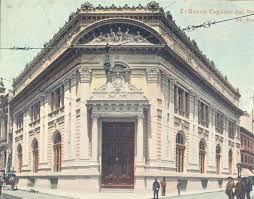
- struggles with refs like *avocat de la terreur* (lawyer of terror) - it suggests nuance, and it's actually a movie
  - this wikimedia dataset has a lot of legal & military content in the sliced sampling, so it is definitely biased for lawyer hits on avocado.
  - 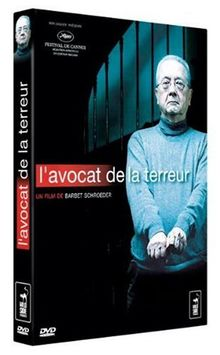

In [ ]:
homonym_dict_filtered  = {
    "bank": {
        "en": "bank",
        "fr": "banque",
        "es": "banco"
    },
    "avocado": {
        "en": "avocado",
        "fr": "avocat",
        "es": ["aguacate","palta"]

    },
    "vino": {
        "en": "wine",
        "fr": "vin",
        "es": "vino"
    }
}

In [30]:
# Prepare a results dictionary grouped by language code
results_bank_by_lang = {lang: [] for lang in homonym_dict_filtered['bank'].keys()}
results_avocado_by_lang = {lang: [] for lang in homonym_dict_filtered['avocado'].keys()}
results_vino_by_lang = {lang: [] for lang in homonym_dict_filtered['vino'].keys()}

In [ ]:
[results_bank_by_lang, results_avocado_by_lang, results_vino_by_lang]
from itertools import islice


{'en': [], 'fr': [], 'es': []}